In [45]:
import lightgbm
import pandas as pd
import numpy as np

In [46]:
def make_class(length,name,thrshold,classes):
    a = np.random.rand(length,1)
    b = np.where(a>thrshold,classes[0],classes[1])
    return pd.DataFrame(b,columns=[name])

In [47]:
a = make_class(100000,'State',0.7,['NY','TX'])
b = make_class(100000,'Phone',0.3,['Ios','Android'])

In [48]:
df = pd.concat([a,b],ignore_index=True,axis=1)
df.columns = ['State','Phone']

In [49]:
df.head(2)

,State,Phone
0,TX,Android
1,TX,Android


In [101]:
# b = df.value_counts().keys()
# mapper = dict(zip(list(b),np.random.rand(4,1).flatten().round(1)))
# mapper

In [103]:
mapper = {('TX', 'Ios'): 0.3,
         ('NY', 'Ios'): 0.85,
         ('TX', 'Android'): 1.0,
         ('NY', 'Android'): 0.0}
mapper

{('TX', 'Ios'): 0.3,
 ('NY', 'Ios'): 0.85,
 ('TX', 'Android'): 1.0,
 ('NY', 'Android'): 0.0}

In [71]:
df['odds']=df.agg(tuple, 1).map(mapper)

In [72]:
df['label'] =np.where(df['odds']>np.random.rand(len(df['odds']),1).flatten(),1,0)

In [73]:
df.groupby(['State','Phone'])['label'].mean()

State  Phone  
NY     Android    0.000000
       Ios        0.845841
TX     Android    1.000000
       Ios        0.298000
Name: label, dtype: float64

In [74]:
df.groupby(['State','Phone'])['label'].agg(['mean','count'])

mean  count
State Phone                   
NY    Android  0.000000   8940
      Ios      0.845841  21147
TX    Android  1.000000  20970
      Ios      0.298000  48943

In [75]:
df=df.drop('odds',axis=1)

In [76]:
y_train = df['label'].astype("bool")
X_train= df[['State','Phone']].copy()

In [77]:
X_train=X_train.astype('category')

In [78]:
train_data = lightgbm.Dataset(X_train, label=y_train,free_raw_data=False)

In [79]:
 best_parameters = {
    'application': 'binary',
    'metric': 'binary_logloss',
    'num_iterations': 1,
    'is_unbalance': 'false',
    'boosting': 'rf',
    'num_leaves': 16,
    "bagging_freq":1,
    "bagging_fraction" : 0.999,
#     'cat_l2':300,
#     'cat_smooth':300,
    'verbose': 5 ,
    'min_split_gain': 1,  # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_samples': 1 # minimum number of data needed in a leaf
}
best_parameters

{'application': 'binary',
 'metric': 'binary_logloss',
 'num_iterations': 1,
 'is_unbalance': 'false',
 'boosting': 'rf',
 'num_leaves': 16,
 'bagging_freq': 1,
 'bagging_fraction': 0.999,
 'verbose': 5,
 'min_split_gain': 1,
 'min_child_samples': 1}

In [80]:
evals_result={}
model = lightgbm.train(best_parameters,
                       train_data,
#                        valid_sets=[train_data, test_data],
                       evals_result=evals_result)

2021-08-10 00:17:50,029 [15485] WARNING  py.warnings:99: [JupyterRequire] /Users/yechiav.yitzchak/.pyenv/versions/3.7.1/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Info] Number of positive: 53442, number of negative: 46558
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.500885
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.002633 seconds
[LightGBM] [Debug] col-wise cost 0.000275 seconds, row-wise cost 0.000251 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534420 -> initscore=0.137898
[LightGBM] [Info] Start training from score 0.137898
[LightGBM] [Debug] Re-bagging, using 99912 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [104]:
# lightgbm.create_tree_digraph(model,show_info='data_percentage')

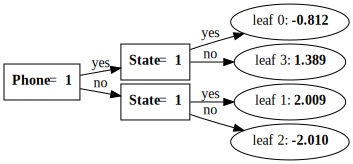

In [92]:
lightgbm.create_tree_digraph(model)

In [93]:
X_train['prob'] = model.predict(X_train[['State','Phone']])

In [94]:
X_train['label'] = df['label']

In [95]:
X_train.groupby(['Phone','State']).agg(['mean','count'])

prob            label       
                   mean  count      mean  count
Phone   State                                  
Android NY     0.118161   8940  0.000000   8940
        TX     0.881748  20970  1.000000  20970
Ios     NY     0.800496  21147  0.845841  21147
        TX     0.307391  48943  0.298000  48943